## import package

In [1]:
from IPython.display import display
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.linalg import Vectors, SparseVector, VectorUDT

In [2]:
import numpy as np
import scipy.sparse
import math
import datetime
import time
import itertools
import pandas as pd
%matplotlib inline

## load data

In [3]:
# train set, test set 불러오기
train = spark.read.format('csv').option("header", "true").load('gs://capstone-03/data/train_sample_df_3.csv')
test = spark.read.format('csv').option("header", "true").load('gs://capstone-03/data/test_sample_df_3.csv')

In [4]:
from pyspark.sql.functions import lit
train = train.withColumn("is_train", lit(1))
test = test.withColumn("is_train", lit(0))

In [8]:
# print((train.count(), len(train.columns)))
# print((test.count(), len(test.columns)))

(1032825, 31)
(272177, 31)


In [5]:
# train set, test set 합치기
union = train.union(test)

In [10]:
# print((union.count(), len(union.columns)))

(1305002, 31)


In [6]:
raw_df = union
raw_df.printSchema()

root
 |-- display_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- label: string (nullable = true)
 |-- is_leak: string (nullable = true)
 |-- weekend: string (nullable = true)
 |-- view_publisher_id: string (nullable = true)
 |-- view_source_id: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- country: string (nullable = true)
 |-- day_event: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- advertiser_id: string (nullable = true)
 |-- ad_category_id: string (nullable = true)
 |-- ad_topic_id: string (nullable = true)
 |-- view_category_id: string (nullable = true)
 |-- view_topic_id: string (nullable = true)
 |-- timestamp_event: string (nullable = true)
 |-- ad_source_id: string (nullable = true)
 |-- ad_publisher_id: string (nullable = true)
 |-- pop_ad_id: string (nullable = true)
 |-- pop_ad_doc_id: string (nullable = true)
 |-- pop_a

In [13]:
# pd.DataFrame(raw_df.take(5), columns=raw_df.columns).transpose()

,0,1,2,3,4
display_id,2790527,4189325,2806444,2783288,55830
ad_id,151311,151311,151311,151311,151311
label,0,1,0,0,0
is_leak,-1,-1,0,-1,-1
weekend,0,0,0,0,0
view_publisher_id,28,450,784,1089,784
view_source_id,353,7736,6698,U,6698
hour,3,1,3,3,6
platform,2,2,2,2,3
traffic_source,1,1,1,3,1


In [7]:
# 'day_event', 'timestamp_event' 제외 (시간 변수는 필요 없어서) 
raw_df = raw_df.select([c for c in raw_df.columns if c not in {'day_event', 'timestamp_event'}])

# 뒤에 outputCol로 'label'을 사용해서, 'label'이 중복되지 않도록, data의 'label' 컬럼명을 "ClickOrNot"로 바꿔준다
raw_df = raw_df.withColumnRenamed("label", "ClickOrNot")

# raw_df를 printSchema 해보기
raw_df.printSchema()
print((raw_df.count(), len(raw_df.columns))) # (1305002, 29)

root
 |-- display_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- ClickOrNot: string (nullable = true)
 |-- is_leak: string (nullable = true)
 |-- weekend: string (nullable = true)
 |-- view_publisher_id: string (nullable = true)
 |-- view_source_id: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- country: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- advertiser_id: string (nullable = true)
 |-- ad_category_id: string (nullable = true)
 |-- ad_topic_id: string (nullable = true)
 |-- view_category_id: string (nullable = true)
 |-- view_topic_id: string (nullable = true)
 |-- ad_source_id: string (nullable = true)
 |-- ad_publisher_id: string (nullable = true)
 |-- pop_ad_id: string (nullable = true)
 |-- pop_ad_doc_id: string (nullable = true)
 |-- pop_ad_publisher_id: string (nullable = true)
 |-- pop_advertiser_id: string (nullable =

## feature engineering - numeric

In [ ]:
# numeric_features 없음, 이 코드 건너뛰기
# numeric_features = [t[0] for t in df.dtypes if t[1] == 'int'] # numeric features 이름 저장
# df.select(numeric_features).describe().toPandas().transpose()

## feature engineering - categorical

In [8]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['weekend', 'view_publisher_id', 'view_source_id', 'hour', 'platform', 'traffic_source', 'country', 'campaign_id', 'advertiser_id', 'ad_category_id', 'ad_topic_id', 'view_category_id', 'view_topic_id', 'ad_source_id', 'ad_publisher_id', 'pop_ad_id', 'pop_ad_doc_id', 'pop_ad_publisher_id', 'pop_advertiser_id', 'pop_campaign_id', 'pop_view_doc_ad_doc', 'pop_ad_source_id', 'pop_ad_topic_id', 'pop_ad_category_id']
# categoricalColumns : 24개
# 사용하지 않은 컬럼 : 5개 ('display_id', 'ad_id', 'ClickOrNot', 'is_leak', 'is_train')
stages = []

In [9]:
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

## feature engineering - label

In [10]:
label_stringIdx = StringIndexer(inputCol = 'ClickOrNot', outputCol = 'label')
stages += [label_stringIdx]

## feature engineering - assembler (categorical)

In [11]:
assemblerInputs = [c + "classVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

## feature engineering - assembler (numeric)

In [ ]:
# numeric_features 없음, 이 코드 건너뛰기
# numericCols = []
# assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
# assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
# stages += [assembler]

## pipeline

In [12]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(raw_df)
transform_df = pipelineModel.transform(raw_df)
cols = raw_df.columns
selectedCols = ['label', 'features'] + cols
selected_df = transform_df.select(selectedCols)

In [13]:
selected_df.printSchema()
print((selected_df.count(), len(selected_df.columns))) # 29 -> 31  : new columns('label', 'features') are added

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- display_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- ClickOrNot: string (nullable = true)
 |-- is_leak: string (nullable = true)
 |-- weekend: string (nullable = true)
 |-- view_publisher_id: string (nullable = true)
 |-- view_source_id: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- country: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- advertiser_id: string (nullable = true)
 |-- ad_category_id: string (nullable = true)
 |-- ad_topic_id: string (nullable = true)
 |-- view_category_id: string (nullable = true)
 |-- view_topic_id: string (nullable = true)
 |-- ad_source_id: string (nullable = true)
 |-- ad_publisher_id: string (nullable = true)
 |-- pop_ad_id: string (nullable = true)
 |-- pop_ad_doc_id: string (nullable = true)
 |-- pop_ad_pub

In [27]:
pd.DataFrame(selected_df.take(5), columns=selected_df.columns).transpose()

,0,1,2,3,4
label,0,1,0,0,0
features,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
display_id,2790527,4189325,2806444,2783288,55830
ad_id,151311,151311,151311,151311,151311
ClickOrNot,0,1,0,0,0
is_leak,-1,-1,0,-1,-1
weekend,0,0,0,0,0
view_publisher_id,28,450,784,1089,784
view_source_id,353,7736,6698,U,6698
hour,3,1,3,3,6


In [122]:
# print(type(selected_df))

pyspark.sql.dataframe.DataFrame

In [ ]:
selected_pd = selected_df["features"].toPandas()

## train, valid split

In [14]:
train = selected_df.filter(selected_df.is_train==1)
test = selected_df.filter(selected_df.is_train==0)

In [15]:
train, valid = selected_df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Validation Dataset Count: " + str(valid.count()))

Training Dataset Count: 912823
Validation Dataset Count: 391677


## 1. logistic regression model

### 1.1 logistic regression - training

In [16]:
import datetime
start_time = time.time()

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10) # x는 'features', y는 'label'
lrModel = lr.fit(train) # 로지스틱 회귀 모델 트레이닝 시키기

print("--- %s seconds ---" % (time.time() - start_time))

--- 53.0223429203 seconds ---


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


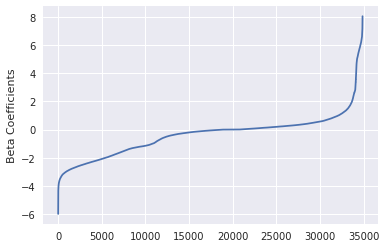

In [17]:
# coef
import matplotlib.pyplot as plt
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()
# 회귀 계수가 34867개, 값은 -6~8 사이에 분포

In [18]:
# print(len(beta))
# print(min(beta))
# print(max(beta))

34867
-5.993986576022735
8.06007812170629


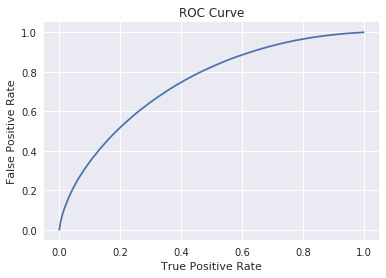

In [19]:
# ROC curve
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

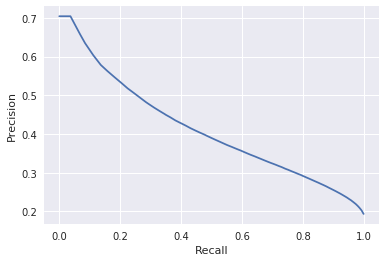

Training set areaUnderROC: 0.74035888469


In [20]:
# precision and recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### 1.2 logistic regression - validation

In [21]:
# prediction
lrPredictions = lrModel.transform(valid)
lrPredictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- display_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- ClickOrNot: string (nullable = true)
 |-- is_leak: string (nullable = true)
 |-- weekend: string (nullable = true)
 |-- view_publisher_id: string (nullable = true)
 |-- view_source_id: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- country: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- advertiser_id: string (nullable = true)
 |-- ad_category_id: string (nullable = true)
 |-- ad_topic_id: string (nullable = true)
 |-- view_category_id: string (nullable = true)
 |-- view_topic_id: string (nullable = true)
 |-- ad_source_id: string (nullable = true)
 |-- ad_publisher_id: string (nullable = true)
 |-- pop_ad_id: string (nullable = true)
 |-- pop_ad_doc_id: string (nullable = true)
 |-- pop_ad_pub

In [22]:
# lrPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|   1081731|152055|       0.0|[0.76129631585395...|
|   3913279|152057|       0.0|[0.76203140932029...|
|   7458692| 99212|       0.0|[0.75418243465143...|
|  11560018|134138|       0.0|[0.77065209610854...|
|   4170347|  9654|       0.0|[0.89919481341470...|
|   1411158|154873|       0.0|[0.87229286437417...|
|   8787510| 34906|       0.0|[0.98808825086495...|
|   7706137|195697|       0.0|[0.88627140062789...|
|  12958619|223540|       0.0|[0.94814998152488...|
|  12958619|243487|       0.0|[0.84796579062123...|
+----------+------+----------+--------------------+
only showing top 10 rows



In [23]:
# evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Validation Area Under ROC', evaluator.evaluate(lrPredictions))

('Validation Area Under ROC', 0.73977552542839)


### 1.3 logistic regression - testing

In [24]:
# prediction
lrPredictions = lrModel.transform(test)
lrPredictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- display_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- ClickOrNot: string (nullable = true)
 |-- is_leak: string (nullable = true)
 |-- weekend: string (nullable = true)
 |-- view_publisher_id: string (nullable = true)
 |-- view_source_id: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- country: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- advertiser_id: string (nullable = true)
 |-- ad_category_id: string (nullable = true)
 |-- ad_topic_id: string (nullable = true)
 |-- view_category_id: string (nullable = true)
 |-- view_topic_id: string (nullable = true)
 |-- ad_source_id: string (nullable = true)
 |-- ad_publisher_id: string (nullable = true)
 |-- pop_ad_id: string (nullable = true)
 |-- pop_ad_doc_id: string (nullable = true)
 |-- pop_ad_pub

In [25]:
lrPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|  15545104|  1419|       0.0|[0.83584025903596...|
|  15523904|   784|       0.0|[0.98907946132185...|
|  16731814|   949|       0.0|[0.99449288156133...|
|  13517470|492732|       0.0|[0.75908094180666...|
|  14303795|492733|       0.0|[0.69496098289604...|
|  13473156|492732|       0.0|[0.62109731036974...|
|  14323230|492733|       0.0|[0.83317909395105...|
|  13529851|  2425|       0.0|[0.92671064982825...|
|  16652787|492733|       0.0|[0.72769099850367...|
|  16745936|492733|       0.0|[0.77593326529769...|
+----------+------+----------+--------------------+
only showing top 10 rows



In [26]:
# evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(lrPredictions))

('Test Area Under ROC', 0.7385219345974261)


## 2. random forest

### 2.1 random forest - training & validation

In [27]:
import datetime
start_time = time.time()

from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
rfPredictions = rfModel.transform(valid)
%time rfPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

print("--- %s seconds ---" % (time.time() - start_time))

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|   1081731|152055|       0.0|[0.8055393711712,...|
|   3913279|152057|       0.0|[0.8055393711712,...|
|   7458692| 99212|       0.0|[0.8055393711712,...|
|  11560018|134138|       0.0|[0.8055393711712,...|
|   4170347|  9654|       0.0|[0.8055393711712,...|
|   1411158|154873|       0.0|[0.8055393711712,...|
|   8787510| 34906|       0.0|[0.85283795087829...|
|   7706137|195697|       0.0|[0.8055393711712,...|
|  12958619|223540|       0.0|[0.8055393711712,...|
|  12958619|243487|       0.0|[0.8055393711712,...|
+----------+------+----------+--------------------+
only showing top 10 rows

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.02 s
--- 287.48152709 seconds ---


In [28]:
print(rfModel.featureImportances)
# spark에는 random forest 변수 중요도 시각화 기능이 없어요, 대신 아래와 같이 리스트를 반환
# feature 개수 : 34867
# 첫번째 리스트 : 변수 index
# 두번째 리스트 : 해당 변수 index의 weight
# 참고 -> https://stackoverflow.com/questions/37878519/understanding-spark-randomforest-featureimportances-results

(34867,[4,6,8,13,14,17,38,40,55,62,63,64,70,82,91,99,104,105,125,128,137,139,173,195,202,226,231,248,267,332,333,368,388,430,461,463,466,467,468,482,483,485,489,506,511,516,518,533,537,542,547,551,562,578,579,582,592,594,607,613,692,696,709,732,772,774,820,823,837,849,1034,1072,1086,1184,1261,1396,1426,1500,1605,1808,1838,1910,2788,2790,2792,2793,2794,2795,2802,2809,2811,2812,2816,2825,2843,2862,2872,2900,2903,2911,2915,2916,3063,3097,3111,3130,3149,3301,3302,3405,3411,3418,3696,3830,4028,4055,4230,4943,5168,11709,12179,12315,12913,24684,24687,24688,24689,24690,24691,24699,24702,24725,24844,24887,24924,24941,24950,25011,25060,25145,25149,25276,25638,28151,28152,28157,28159,28168,28251,28254,28255,28262,28277,28348,28421,28448,28478,28546,28548,28549,28554,28555,28561,28564,28570,28572,28578,28585,28587,28588,28598,28600,28608,28609,28618,28634,28635,28638,28642,28643,28653,28655,28657,28666,28669,28671,28673,28677,28686,28687,28690,28702,28707,28715,28719,28722,28730,28733,28739,28749,

In [29]:
evaluator = BinaryClassificationEvaluator()
print("Validation Area Under ROC: " + str(evaluator.evaluate(rfPredictions, {evaluator.metricName: "areaUnderROC"})))

Validation Area Under ROC: 0.600925704267


### 2.2 random forest - testing

In [30]:
rfPredictions = rfModel.transform(test)
%time rfPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|  15545104|  1419|       0.0|[0.80392577324733...|
|  15523904|   784|       0.0|[0.8055393711712,...|
|  16731814|   949|       0.0|[0.80392577324733...|
|  13517470|492732|       0.0|[0.8055393711712,...|
|  14303795|492733|       0.0|[0.80392577324733...|
|  13473156|492732|       0.0|[0.8055393711712,...|
|  14323230|492733|       0.0|[0.80748568400145...|
|  13529851|  2425|       0.0|[0.8055393711712,...|
|  16652787|492733|       0.0|[0.80392577324733...|
|  16745936|492733|       0.0|[0.80392577324733...|
+----------+------+----------+--------------------+
only showing top 10 rows

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 18.9 s


In [31]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(rfPredictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.593543776154


## 3. gradient-boosted tree

### 3.1 gradient-boosted tree - training & validation

In [32]:
import datetime
start_time = time.time()

from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
gbtPredictions = gbtModel.transform(valid)
%time gbtPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

print("--- %s seconds ---" % (time.time() - start_time))

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|   1081731|152055|       0.0|[0.80062090727890...|
|   3913279|152057|       0.0|[0.80062090727890...|
|   7458692| 99212|       0.0|[0.80062090727890...|
|  11560018|134138|       0.0|[0.80062090727890...|
|   4170347|  9654|       0.0|[0.80062090727890...|
|   1411158|154873|       0.0|[0.80062090727890...|
|   8787510| 34906|       0.0|[0.88133923875054...|
|   7706137|195697|       0.0|[0.80062090727890...|
|  12958619|223540|       0.0|[0.82013799086042...|
|  12958619|243487|       0.0|[0.80062090727890...|
+----------+------+----------+--------------------+
only showing top 10 rows

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 5.1 s
--- 2391.42443514 seconds ---


In [33]:
evaluator = BinaryClassificationEvaluator()
print("Validation Area Under ROC: " + str(evaluator.evaluate(gbtPredictions, {evaluator.metricName: "areaUnderROC"})))

Validation Area Under ROC: 0.62079337408


### 3.2 gradient-boosted tree - testing

In [34]:
gbtPredictions = gbtModel.transform(test)
%time gbtPredictions.select('display_id', 'ad_id', 'prediction', 'probability').show(10)

+----------+------+----------+--------------------+
|display_id| ad_id|prediction|         probability|
+----------+------+----------+--------------------+
|  15545104|  1419|       0.0|[0.80062090727890...|
|  15523904|   784|       0.0|[0.80062090727890...|
|  16731814|   949|       0.0|[0.77492917104812...|
|  13517470|492732|       0.0|[0.80062090727890...|
|  14303795|492733|       0.0|[0.77492917104812...|
|  13473156|492732|       0.0|[0.80062090727890...|
|  14323230|492733|       0.0|[0.77492917104812...|
|  13529851|  2425|       0.0|[0.80062090727890...|
|  16652787|492733|       0.0|[0.77492917104812...|
|  16745936|492733|       0.0|[0.77492917104812...|
+----------+------+----------+--------------------+
only showing top 10 rows

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.2 s


In [35]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(gbtPredictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.612009301179
